# 7 Recurrent neural networks
In this exercise we will try a simple experiment with a recurrent neural network. One of the well-known recurrent neural network models is the so called Long short-term memory (LSTM) network. More information on LSTM can be found in the text [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

## 7.1 The MNIST dataset revisited (1)
In one of the previous exercises the MNIST dataset was used to demonstrate the use of multilayer perceptron. Here we are going to apply a recurrent neural network to the problem of digits classification. To keep it simple, we will use a simple LSTM network that will be fed with one row of the image at a time. With each new row, it will update its states and give its prediction. What we are interested in is its prediction after the last row i.e. after it has the full information.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Constants
learning_rate = 0.001
num_epochs = 10
batch_size = 100
#we will feed a row at a time to the LSTM and there are 28 rows per image
timesteps = 28
#each row has 28 columns whose values are simultaneously passed to LSTM
n_input = 28 # MNIST data input (img shape: 28*28)
#the number of hidden states in the LSTM
n_hidden = 128
n_classes = 10

# Data transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model
device = torch.device('cuda')
model = LSTMModel(n_input, n_hidden, 1, n_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, timesteps, n_input).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Test the model
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, timesteps, n_input).to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

3.3%

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%
11.9%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%
100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Epoch [1/10], Test Accuracy: 96.07%
Epoch [2/10], Test Accuracy: 97.66%
Epoch [3/10], Test Accuracy: 98.01%
Epoch [4/10], Test Accuracy: 98.32%
Epoch [5/10], Test Accuracy: 98.25%
Epoch [6/10], Test Accuracy: 98.79%
Epoch [7/10], Test Accuracy: 98.59%
Epoch [8/10], Test Accuracy: 97.95%
Epoch [9/10], Test Accuracy: 98.51%
Epoch [10/10], Test Accuracy: 98.58%


**Tasks**

1. Study and run the code above.
2. Draw a plot that shows the relation between the number of rows given to the network and its final accuracy on the test set.
3. What happens if we use gradient descent instead of Adam?


Epoch [1/10], Test Accuracy: 96.44%
Epoch [2/10], Test Accuracy: 97.87%
Epoch [3/10], Test Accuracy: 97.50%
Epoch [4/10], Test Accuracy: 97.71%
Epoch [5/10], Test Accuracy: 98.13%
Epoch [6/10], Test Accuracy: 97.98%
Epoch [7/10], Test Accuracy: 98.20%
Epoch [8/10], Test Accuracy: 98.45%
Epoch [9/10], Test Accuracy: 98.38%
Epoch [10/10], Test Accuracy: 98.48%
Timesteps: 7, Accuracy: 98.48%
Epoch [1/10], Test Accuracy: 97.12%
Epoch [2/10], Test Accuracy: 97.08%
Epoch [3/10], Test Accuracy: 98.10%
Epoch [4/10], Test Accuracy: 98.59%
Epoch [5/10], Test Accuracy: 98.68%
Epoch [6/10], Test Accuracy: 98.61%
Epoch [7/10], Test Accuracy: 98.46%
Epoch [8/10], Test Accuracy: 98.65%
Epoch [9/10], Test Accuracy: 98.82%
Epoch [10/10], Test Accuracy: 98.77%
Timesteps: 14, Accuracy: 98.77%
Epoch [1/10], Test Accuracy: 96.64%
Epoch [2/10], Test Accuracy: 97.76%
Epoch [3/10], Test Accuracy: 97.96%
Epoch [4/10], Test Accuracy: 97.83%
Epoch [5/10], Test Accuracy: 97.96%
Epoch [6/10], Test Accuracy: 98.33%

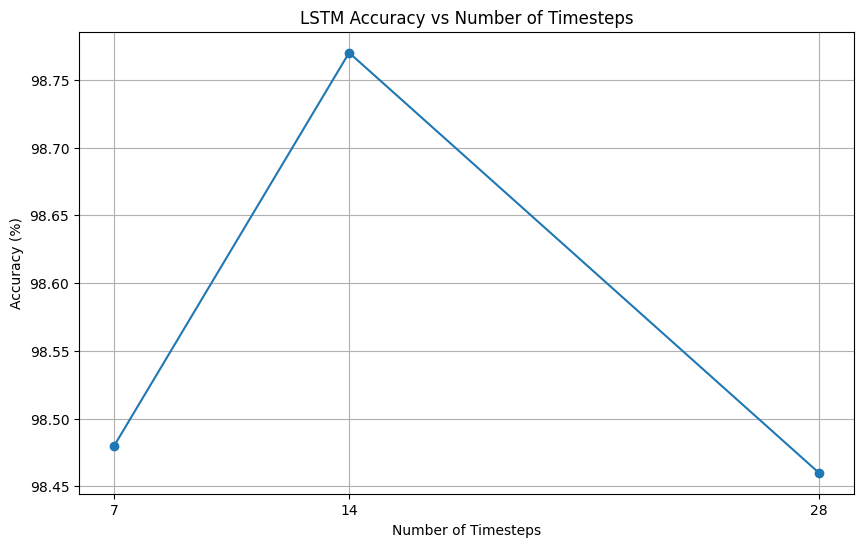

In [5]:
#2

import matplotlib.pyplot as plt
import numpy as np

# Adjust the model to accept different timesteps
class FlexibleLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, timesteps):
        super(FlexibleLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.timesteps = timesteps
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Function to train and evaluate the model
def train_and_evaluate(timesteps):
    # Adjust the input dimensions based on the number of timesteps
    n_input = 28 * (28 // timesteps)

    # Initialize the model for the given timesteps
    model = FlexibleLSTMModel(n_input, n_hidden, 1, n_classes, timesteps).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Adjust image shape based on timesteps
            images = images.view(-1, timesteps, n_input).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Test the model
        if (epoch + 1) % 1 == 0:
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.view(-1, timesteps, n_input).to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.view(-1, timesteps, n_input).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy

# Timesteps to evaluate
timestep_options = [7, 14, 28]
accuracies = []

# Evaluate the model for each timestep option
for timesteps in timestep_options:
    accuracy = train_and_evaluate(timesteps)
    accuracies.append(accuracy)
    print(f'Timesteps: {timesteps}, Accuracy: {accuracy:.2f}%')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(timestep_options, accuracies, marker='o')
plt.title('LSTM Accuracy vs Number of Timesteps')
plt.xlabel('Number of Timesteps')
plt.ylabel('Accuracy (%)')
plt.xticks(timestep_options)
plt.grid(True)
plt.show()


In [13]:
#3

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Constants
learning_rate = 0.001
num_epochs = 10
batch_size = 100
#we will feed a row at a time to the LSTM and there are 28 rows per image
timesteps = 28
#each row has 28 columns whose values are simultaneously passed to LSTM
n_input = 28 # MNIST data input (img shape: 28*28)
#the number of hidden states in the LSTM
n_hidden = 128
n_classes = 10

# Data transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model
device = torch.device('cuda')
model = LSTMModel(n_input, n_hidden, 1, n_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, timesteps, n_input).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Test the model
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, timesteps, n_input).to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

Epoch [1/10], Test Accuracy: 11.48%
Epoch [2/10], Test Accuracy: 11.45%
Epoch [3/10], Test Accuracy: 11.42%
Epoch [4/10], Test Accuracy: 11.41%
Epoch [5/10], Test Accuracy: 11.41%
Epoch [6/10], Test Accuracy: 11.47%
Epoch [7/10], Test Accuracy: 11.56%
Epoch [8/10], Test Accuracy: 11.78%
Epoch [9/10], Test Accuracy: 12.04%
Epoch [10/10], Test Accuracy: 12.45%


# 8 Convolutional neural networks


The goal of this exercise is to learn the basic stuff about [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN or ConvNet). In the previous exercises, the building blocks mostly included simple operations that had some kind of activations functions and each layer was usually fully connected to the previous one. CNNs take into account the spatial nature of the input data, e.g. an image, and they process it by applying one or more  [kernels](https://en.wikipedia.org/wiki/Kernel_%28image_processing%29). In the case of images, this processing i.e. convolving is also known as filtering. The results of processing the input with a single kernel will be a single channel, but usually a convolutional layer involves more kernels producing more channels. These channels are often called **feature maps** because each kernel is specialized for extraction of a certain kind of features from the input. These feature maps are then combined into a single tensor that can be viewed as an image with multiple channels that can be then passed to further convolutional layers.

For example, if the input consists of a grayscale image i.e. an image with only one channel and a $5\times 5$ kernel is applied, the result is a single feature map. The borders of the input image are usually padded with zeros to ensure that the resulting feature maps has the same number of rows and columns as the input image.

If the input consists of a color image i.e. an image with three channels and a $5\times 5$ kernel is applied, what will actually be applied is an $5\times 5\times 3$ kernel that will simultaneously process all three channels and the result will again be a single feature map. However, if e.g. 16 several kernels are applied, then the result will be 16 feature maps. Should they be passed to another convolutional layer, **each** of its kernels would simultaneously process **all** feature maps so their sizes would be e.g. $3\times 3\times 16$ or $5\times 5\times 16$ where 16 is used to reach all feature maps simultaneously.

The convolution is usually followed by applying an element-wise non-linear operation to each of the values in the feature maps. Finally, what often follows is the summarization i.e. pooling of the information in the feature maps to reduce the spatial dimensions and keep only the most important information. A common approach used here is the so called max pooling. It is a non-linear downsampling where the input is divided into a set of non-overlapping rectangles and for each of them only the maximum value inside of it is kept.

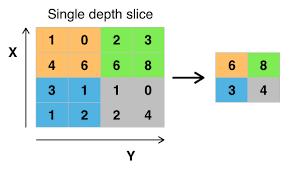
<center>Figure 1. Max pooling with $2\times 2$ rectangles (taken from [Wikipedia](https://en.wikipedia.org/wiki/File:Max_pooling.png)).</center>

What usually follows after several convolutional layers is putting the values of all feature maps into a single vector, which is then passed further to fully connected or other kinds of layers.

The number of parameters in the convolutional depends on the number of feature maps and the sizes of the kernels. For example, if a convolutional layer with 32 kernels of nominal size $3\times 3$ receives 16 feature maps on its input, it will require $16\times 3\times 3\times 32+32$ where the last 32 parameters refer to the kernel biases.

### Google Colab preliminaries

Upload the zipped cnn_img folder to Google Colab and ensure the paths in the notebook are adjusted accordingly.

If the notebook is not run on Google Colab, skip the following commands.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip /content/cnn_img.zip

## 8.1 The MNIST dataset revisited (2)
In one of the previous exercises the MNIST dataset was used to demonstrate the use of multilayer perceptron. Here we are going to apply a convolutional neural network to the digit classification problem. We will use the following layers to build our model:

* [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
* [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
* [torch.nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
* [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)

The [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layer has the same effect as the fully connected layer, a matrix multiplication that was used in the previous exercise with the MNIST dataset.

**Tasks**

1. Study and run the code below. How is the accuracy compared to the ones obtained in the previous exerises with MNIST?
2. Try to change the number and size of convolutional and fully connected layers. What has the greatest impact on the accuracy? For each network architecture configuration calculate the number of trainable parameters.
3. What happens to the accuracy if another [non-linearity](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) is used instead of ReLU? Experiment with at least two different activation functions.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import tqdm

In [8]:
class CNN(nn.Module):

  # Method that defines the layers and other components of a model
  def __init__(self,
               input_channels,
               n_channels_1,
               n_channels_2,
               n_fully_connected,
               n_classes,
               kernel_size
               ):

    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=input_channels,
                           out_channels=n_channels_1,
                           kernel_size=kernel_size,
                           padding='same'
                           )

    self.relu1 = nn.ReLU()

    self.maxpool1 = nn.MaxPool2d((2,2))

    self.conv2 = nn.Conv2d(in_channels=n_channels_1,
                           out_channels=n_channels_2,
                           kernel_size=kernel_size,
                           padding='same'
                           )

    self.relu2 = nn.ReLU()

    self.maxpool2 = nn.MaxPool2d((2,2))

    self.fc1 = nn.Linear(in_features=7*7*n_channels_2, out_features=n_fully_connected, bias=True)

    self.relu3 = nn.ReLU()

    self.fc2 = nn.Linear(in_features=n_fully_connected, out_features=n_classes, bias=True)

  # Method where the computation gets done
  def forward(self, x):

    # First convolutional layer
    # We will apply n_channels_1 kernels of size kernel_size X kernel_size
    # We are padding the input in order for the result to have the same number of rows and columns
    x = self.conv1(x)

    # Applying the non-linearity
    x = self.relu1(x)

    # and max pooling again, now each feature map will be of size 7 X 7
    x = self.maxpool1(x)

    # Second convolutional layer
    # We will apply n_channels_2 kernels of size kernel_size X kernel_size
    x = self.conv2(x)

    # again, we apply the non-linearity
    x = self.relu2(x)

    # and max pooling again, now each feature map will be of size 7 X 7
    x = self.maxpool2(x)

    # Flatten all dimensions except the batch
    x = torch.flatten(x, 1)

    # Fully connected layer
    x = self.fc1(x)

    # and again, we apply the non-linearity
    x = self.relu3(x)

    # Non-linearity
    pred_logits = self.fc2(x)

    return pred_logits


In [9]:
def train_epoch(model, device, train_dataloader, optimizer, epoch):

    model.train()

    train_loss = 0.0

    for batch in tqdm.tqdm(train_dataloader):

      # Every data instance is an input image + label pair
      images, labels = batch

      # It is necessary to have both the model, and the data on the same device, either CPU or GPU, for the model to process data.
      # Data on CPU and model on GPU, or vice-versa, will result in a Runtime error.
      images, labels = images.to(device), labels.to(device)

      # Zero your gradients for every batch
      optimizer.zero_grad()

      # Make predictions for this batch
      pred_logits = model(images)

      # Compute the loss
      loss = loss_fn(pred_logits, labels)

      # Calculates the backward gradients over the learning weights
      loss.backward()

      # Tells the optimizer to perform one learning step
      # Adjust the model�s learning weights based on the observed gradients for this batch
      optimizer.step()

      train_loss += loss.item()

    # Print epoch's average loss
    print("Epoch {} - Training loss: {}".format(epoch+1, train_loss/len(train_dataloader)))


def evaluation(model, device, test_dataloader, epoch):

    # Sets layers like dropout and batch normalization to evaluation mode before running inference
    # Failing to do this will yield inconsistent inference results
    model.eval()

    test_accuracy = 0.0

    # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward().
    # It will reduce memory consumption for computations that would otherwise have requires_grad=True.
    with torch.no_grad():

      for batch in tqdm.tqdm(test_dataloader):

        images, labels = batch

        images, labels = images.to(device), labels.to(device)

        pred_logits = model(images)

        probabilities = torch.nn.functional.softmax(pred_logits, dim=1)

        # Find the index of the highest probability
        predictions = probabilities.argmax(dim=1)

        # Caluculate average batch accuracy
        batch_accuracy = torch.mean((predictions == labels).float())

        test_accuracy += batch_accuracy

      print("Epoch {} - Accuracy: {}".format(epoch+1, test_accuracy/len(test_dataloader)))




In [10]:
# Architecture configs
input_channels=1
n_channels_1=32
n_channels_2=64
n_classes=10
n_fully_connected=128
kernel_size=5

# Training configs
training_epochs_count = 5
batch_size = 64
learning_rate = 0.001
display_step=1

# Model
model = CNN(input_channels, n_channels_1, n_channels_2, n_fully_connected, n_classes, kernel_size)

# Move model to GPU if possible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Augmentations
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Stores the samples and their corresponding labels
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

# Wraps an iterable around the Dataset to enable easy access to the samples.
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100.0%


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



100.0%
11.9%

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



100.0%


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



100.0%

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



In [11]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
for epoch in range(training_epochs_count):

  train_epoch(model, device, train_dataloader, optimizer, epoch)

  if (epoch + 1) % display_step == 0:

    evaluation(model, device, test_dataloader, epoch)



100%|██████████| 938/938 [00:11<00:00, 83.85it/s]


Epoch 1 - Training loss: 0.11855150967104626


100%|██████████| 157/157 [00:01<00:00, 112.07it/s]


Epoch 1 - Accuracy: 0.978204607963562


100%|██████████| 938/938 [00:12<00:00, 77.24it/s]


Epoch 2 - Training loss: 0.04099489355970275


100%|██████████| 157/157 [00:01<00:00, 114.03it/s]


Epoch 2 - Accuracy: 0.9892516136169434


100%|██████████| 938/938 [00:12<00:00, 76.24it/s]


Epoch 3 - Training loss: 0.026979705118665424


100%|██████████| 157/157 [00:01<00:00, 114.52it/s]


Epoch 3 - Accuracy: 0.9922372698783875


100%|██████████| 938/938 [00:12<00:00, 76.29it/s]


Epoch 4 - Training loss: 0.01965317696946796


100%|██████████| 157/157 [00:01<00:00, 115.61it/s]


Epoch 4 - Accuracy: 0.9894506335258484


100%|██████████| 938/938 [00:11<00:00, 82.42it/s]


Epoch 5 - Training loss: 0.016736006800093434


100%|██████████| 157/157 [00:01<00:00, 116.34it/s]

Epoch 5 - Accuracy: 0.990545392036438


In [16]:
#tasks - sigmoida umjesto relu

class CNN(nn.Module):

  # Method that defines the layers and other components of a model
  def __init__(self,
               input_channels,
               n_channels_1,
               n_channels_2,
               n_fully_connected,
               n_classes,
               kernel_size
               ):

    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=input_channels,
                           out_channels=n_channels_1,
                           kernel_size=kernel_size,
                           padding='same'
                           )

    self.relu1 = nn.Sigmoid()

    self.maxpool1 = nn.MaxPool2d((2,2))

    self.conv2 = nn.Conv2d(in_channels=n_channels_1,
                           out_channels=n_channels_2,
                           kernel_size=kernel_size,
                           padding='same'
                           )

    self.relu2 = nn.Sigmoid()

    self.maxpool2 = nn.MaxPool2d((2,2))

    self.fc1 = nn.Linear(in_features=7*7*n_channels_2, out_features=n_fully_connected, bias=True)

    self.relu3 = nn.Sigmoid()

    self.fc2 = nn.Linear(in_features=n_fully_connected, out_features=n_classes, bias=True)

  # Method where the computation gets done
  def forward(self, x):

    # First convolutional layer
    # We will apply n_channels_1 kernels of size kernel_size X kernel_size
    # We are padding the input in order for the result to have the same number of rows and columns
    x = self.conv1(x)

    # Applying the non-linearity
    x = self.relu1(x)

    # and max pooling again, now each feature map will be of size 7 X 7
    x = self.maxpool1(x)

    # Second convolutional layer
    # We will apply n_channels_2 kernels of size kernel_size X kernel_size
    x = self.conv2(x)

    # again, we apply the non-linearity
    x = self.relu2(x)

    # and max pooling again, now each feature map will be of size 7 X 7
    x = self.maxpool2(x)

    # Flatten all dimensions except the batch
    x = torch.flatten(x, 1)

    # Fully connected layer
    x = self.fc1(x)

    # and again, we apply the non-linearity
    x = self.relu3(x)

    # Non-linearity
    pred_logits = self.fc2(x)

    return pred_logits


# Architecture configs
input_channels=1
n_channels_1=32
n_channels_2=64
n_classes=10
n_fully_connected=128
kernel_size=5

# Training configs
training_epochs_count = 5
batch_size = 64
learning_rate = 0.001
display_step=1

# Model
model = CNN(input_channels, n_channels_1, n_channels_2, n_fully_connected, n_classes, kernel_size)

# Move model to GPU if possible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Augmentations
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Stores the samples and their corresponding labels
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

# Wraps an iterable around the Dataset to enable easy access to the samples.
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
for epoch in range(training_epochs_count):

  train_epoch(model, device, train_dataloader, optimizer, epoch)

  if (epoch + 1) % display_step == 0:

    evaluation(model, device, test_dataloader, epoch)



  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:11<00:00, 84.13it/s]


Epoch 1 - Training loss: 0.608868547494827


100%|██████████| 157/157 [00:01<00:00, 109.49it/s]


Epoch 1 - Accuracy: 0.9650676846504211


100%|██████████| 938/938 [00:10<00:00, 86.22it/s]


Epoch 2 - Training loss: 0.09549751555296912


100%|██████████| 157/157 [00:01<00:00, 112.91it/s]


Epoch 2 - Accuracy: 0.9791003465652466


100%|██████████| 938/938 [00:12<00:00, 77.19it/s]


Epoch 3 - Training loss: 0.06146274792796958


100%|██████████| 157/157 [00:01<00:00, 114.12it/s]


Epoch 3 - Accuracy: 0.9858678579330444


100%|██████████| 938/938 [00:12<00:00, 77.42it/s]


Epoch 4 - Training loss: 0.045892170491640266


100%|██████████| 157/157 [00:01<00:00, 113.82it/s]


Epoch 4 - Accuracy: 0.9855692982673645


100%|██████████| 938/938 [00:11<00:00, 82.65it/s]


Epoch 5 - Training loss: 0.03697690545436817


100%|██████████| 157/157 [00:01<00:00, 117.51it/s]

Epoch 5 - Accuracy: 0.9863654375076294


## 8.2 Image classification
Image classification is a challenging computer vision problem with the best-known competition being [The ImageNet Large Scale Visual Recognition Challenge (ILSVRC)](http://www.image-net.org/challenges/LSVRC/), which includes the ImageNet dataset with millions of $224\times 224$ training images. The class names in one of the tasks there can be found [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). One of the most important breakthroughs was when in 2012 the convolutional neural network [AlexNet](https://en.wikipedia.org/wiki/AlexNet) won the first place. Ever since many highly successful convolutional neural networks architectures have been proposed, e.g. [VGG-16](https://arxiv.org/abs/1409.1556), [VGG-19](https://arxiv.org/abs/1409.1556), [ResNet](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), [Inception](https://arxiv.org/abs/1409.4842), etc. Training such networks requires a lot of time because they have many layers with millions of parameters. In this exercise we are going to experiment with pre-trained models of some of the best known architectures.

### 8.2.1 Using pre-trained models
Try running the following code:

In [19]:
import torchvision.models as models
from torchvision.io import read_image

### Choose the architecture
architecture="resnet34"
#architecture="vgg16"
#architecture="vgg19"
#architecture="inceptionv3"

if architecture == "resnet34":
  weights = models.ResNet34_Weights.DEFAULT
  model = models.resnet34(weights=weights)
elif architecture == "vgg16":
  weights = models.VGG16_Weights.DEFAULT
  model = models.vgg16(pretrained=weights)
elif architecture == "vgg19":
  weights = models.VGG19_Weights.DEFAULT
  model = models.vgg19(pretrained=weights)
elif architecture == "inceptionv3":
  weights = models.Inception_V3_Weights.DEFAULT
  model = models.inception_v3(pretrained=weights)

model.eval()

image_paths=["./cnn_img/badger.jpg", "./cnn_img/rabbit.jpg", "./cnn_img/sundial.jpg", "./cnn_img/pineapple.jpg", "./cnn_img/can.jpg"]

for path in image_paths:
    #loading the image and rescaling it to fit the size for the imagenet architectures
    img = read_image(path)
    preprocess = weights.transforms(antialias=True)
    batch = preprocess(img).unsqueeze(0)

    prediction = model(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]

    print(f"{category_name}: {100 * score:.1f}%")

badger: 99.5%
wood rabbit: 89.4%
sundial: 100.0%
pineapple: 100.0%
table lamp: 38.9%


**Tasks**
1. Is there any significant difference between the results of different architectures?
2. Try to classify several other images from the folders cnn_img/healthy and cnn_img/unhealthy that you choose on your own. Which cases are problematic?

### 8.2.2 Creating your own classifier - pincers vs. scissors
Although ImageNet has a lot of classes, sometimes they do not cover some desired cases. Let's assume that we want to tell images with pincers apart from the ones with scissors. Neither pincers nor scissors are among ImageNet classes. Nevertheless, we can still use some parts of the pre-trained models.

Various layers of a deep convolutional network have diferent tasks. The ones closest to the original input image usually look for features such as edges and corners i.e. for low-level features. After them there are layers that look for middle-level features such as circular objects, special curves, etc. Next, there are usually fully connected layers that create high-level semantic features by combining the information from the previous layers. These features are then used by the last layer that performs the actual classification. What we can do here is simply to discard the last layer i.e. not to calculate the class of an image, but to extract the values in on of the fully connected layers. This effectively means that we are going to use the network only as an extractor for high-level features that we would hardly be able to engineer on our own. Let's first see which layers can be found in the ResNet network:

In [20]:
import torchvision.models as models
import numpy as np

architecture="resnet34"

if architecture == "resnet34":
  weights = models.ResNet34_Weights.DEFAULT
  base_model = models.resnet34(weights=weights)
elif architecture == "resnet50":
  weights = models.ResNet50_Weights.DEFAULT
  base_model = models.resnet50(weights=weights)
elif architecture == "vgg16":
  weights = models.VGG16_Weights.DEFAULT
  base_model = models.vgg16(weights=weights)

for layer in base_model.children():
    print(layer)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

At the end you can see fully connected layer used for classification. We can extract the values from previous layers by using the following code:

In [23]:
# Model without last fully connected layer
model = torch.nn.Sequential(*(list(base_model.children())[:-1]), nn.AdaptiveAvgPool2d(1))

img_path="./cnn_img/rabbit.jpg"

img = read_image(img_path)
preprocess = weights.transforms(antialias=True)
batch = preprocess(img).unsqueeze(0)

features = model(batch).squeeze(3).squeeze(2)

print(features.shape)
feature_layer_size=features.shape[1]

torch.Size([1, 512])


These values can now be used as features and that can later be used with another classifier. Let's first extract the features for our pincer and scissors images.

In [25]:
def create_numbered_paths(home_dir, n):
    return [home_dir+str(i)+".jpg" for i in range(n)]

def create_paired_numbered_paths(first_home_dir, second_home_dir, n):
    image_paths=[]
    for p in zip(create_numbered_paths(first_home_dir, n), create_numbered_paths(second_home_dir, n)):
        image_paths.extend(p)
    return image_paths

def create_features(paths, verbose=True):
    n=len(paths)
    features=np.zeros((n, feature_layer_size))
    for i in range(n):
        if (verbose==True):
            print("\t%2d / %2d"%(i+1, n))
        img = read_image(paths[i])
        preprocess = weights.transforms(antialias=True)
        batch = preprocess(img).unsqueeze(0)
        features[i, :]=model(batch).squeeze(3).squeeze(2).detach().numpy()

    return features

pincers_dir="./cnn_img/pincers/"
scissors_dir="./cnn_img/scissors/"

individual_n=50

#combining all image paths
image_paths=create_paired_numbered_paths(pincers_dir, scissors_dir, individual_n)

#marking their classes
image_classes=[]
for i in range(individual_n):
    #0 stands for the pincer image and 0 stands for the scissors image
    image_classes.extend((0, 1))

#number of all images
n=100
#number of training images
n_train=50
#number of test images
n_test=n-n_train

print("Creating training features...")
#here we will store the features of training images
x_train=create_features(image_paths[:n_train])
#train classes
y_train=np.array(image_classes[:n_train])

print("Creating test features...")
#here we will store the features of test images
x_test=create_features(image_paths[n_train:])

#train classes
y_test=np.array(image_classes[n_train:])

Creating training features...
	 1 / 50
	 2 / 50
	 3 / 50
	 4 / 50
	 5 / 50
	 6 / 50
	 7 / 50
	 8 / 50
	 9 / 50
	10 / 50
	11 / 50
	12 / 50
	13 / 50
	14 / 50
	15 / 50
	16 / 50
	17 / 50
	18 / 50
	19 / 50
	20 / 50
	21 / 50
	22 / 50
	23 / 50
	24 / 50
	25 / 50
	26 / 50
	27 / 50
	28 / 50
	29 / 50
	30 / 50
	31 / 50
	32 / 50
	33 / 50
	34 / 50
	35 / 50
	36 / 50
	37 / 50
	38 / 50
	39 / 50
	40 / 50
	41 / 50
	42 / 50
	43 / 50
	44 / 50
	45 / 50
	46 / 50
	47 / 50
	48 / 50
	49 / 50
	50 / 50
Creating test features...
	 1 / 50
	 2 / 50
	 3 / 50
	 4 / 50
	 5 / 50
	 6 / 50
	 7 / 50
	 8 / 50
	 9 / 50
	10 / 50
	11 / 50
	12 / 50
	13 / 50
	14 / 50
	15 / 50
	16 / 50
	17 / 50
	18 / 50
	19 / 50
	20 / 50
	21 / 50
	22 / 50
	23 / 50
	24 / 50
	25 / 50
	26 / 50
	27 / 50
	28 / 50
	29 / 50
	30 / 50
	31 / 50
	32 / 50
	33 / 50
	34 / 50
	35 / 50
	36 / 50
	37 / 50
	38 / 50
	39 / 50
	40 / 50
	41 / 50
	42 / 50
	43 / 50
	44 / 50
	45 / 50
	46 / 50
	47 / 50
	48 / 50
	49 / 50
	50 / 50


Now that for each image we have its features, we will divide the images into a training and a test set. Then we will use a linear SVM classifier to classify them.

In [26]:
from sklearn import svm

def create_svm_classifier(x, y, C=1.0, kernel='linear'):
    #we will use linear SVM
    classifier=svm.SVC(kernel=kernel, C=C);
    classifier.fit(x, y)
    return classifier

def calculate_accuracy(classifier, x, y):
    predicted=classifier.predict(x)
    return np.sum(y==predicted)/y.size

In [27]:
#training the model
classifier=create_svm_classifier(x_train, y_train, 1.0, "linear")

#checking the model's accuracy
print("Accuracy: %.2lf%%"%(100*calculate_accuracy(classifier, x_test, y_test)))

Accuracy: 96.00%


**Tasks**

1. Is there any significant gain if more complex SVM models are used?
2. What happens if we extract features using different backbone, e.g. vgg16?


### 8.2.1 Creating your own classifier - healthy vs. unhealthy food
The previous example was relatively simple because all images were of same size and each of them had a white background, which allowed the extractor to concentrate only on the features of the actual objects. In this example we will use a slightly more complicated case - namely, will will tell images with healthy food apart from the ones with unhealthy food. FIrst let's repeat the same process as we did in the previous example and create the features:

In [28]:
healthy_dir="./cnn_img/healthy/"
unhealthy_dir="./cnn_img/unhealthy/"

individual_n=100

#combining all image paths
image_paths=create_paired_numbered_paths(healthy_dir, unhealthy_dir, individual_n)

#marking their classes
image_classes=[]
for i in range(individual_n):
    #0 stands for the pincer image and 0 stands for the scissors image
    image_classes.extend((0, 1))

#number of all images
n=200
#number of training images
n_train=100
#number of test images
n_test=n-n_train

print("Creating training features...")
#here we will store the features of training images
x_train=create_features(image_paths[:n_train])
#train classes
y_train=np.array(image_classes[:n_train])

print("Creating test features...")
#here we will store the features of test images
x_test=create_features(image_paths[n_train:])
#train classes
y_test=np.array(image_classes[n_train:])

Creating training features...
	 1 / 100
	 2 / 100
	 3 / 100
	 4 / 100
	 5 / 100
	 6 / 100
	 7 / 100
	 8 / 100
	 9 / 100
	10 / 100
	11 / 100
	12 / 100
	13 / 100
	14 / 100
	15 / 100
	16 / 100
	17 / 100
	18 / 100
	19 / 100
	20 / 100
	21 / 100
	22 / 100
	23 / 100
	24 / 100
	25 / 100
	26 / 100
	27 / 100
	28 / 100
	29 / 100
	30 / 100
	31 / 100
	32 / 100
	33 / 100
	34 / 100
	35 / 100
	36 / 100
	37 / 100
	38 / 100
	39 / 100
	40 / 100
	41 / 100
	42 / 100
	43 / 100
	44 / 100
	45 / 100
	46 / 100
	47 / 100
	48 / 100
	49 / 100
	50 / 100
	51 / 100
	52 / 100
	53 / 100
	54 / 100
	55 / 100
	56 / 100
	57 / 100
	58 / 100
	59 / 100
	60 / 100
	61 / 100
	62 / 100
	63 / 100
	64 / 100
	65 / 100
	66 / 100
	67 / 100
	68 / 100
	69 / 100
	70 / 100
	71 / 100
	72 / 100
	73 / 100
	74 / 100
	75 / 100
	76 / 100
	77 / 100
	78 / 100
	79 / 100
	80 / 100
	81 / 100
	82 / 100
	83 / 100
	84 / 100
	85 / 100
	86 / 100
	87 / 100
	88 / 100
	89 / 100
	90 / 100
	91 / 100
	92 / 100
	93 / 100
	94 / 100
	95 / 100
	96 / 100
	97 / 100


Now let's train a model and test its accuracy:

In [29]:
classifier=create_svm_classifier(x_train, y_train, 1.0, "linear")
print("Accuracy: %.2lf%%"%(100*calculate_accuracy(classifier, x_test, y_test)))

Accuracy: 65.00%


**Tasks**
1. Try the whole food classification with another network as a feature extractor and compare their results.
2. What kind of test images are problematic?